In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
high_cutoff_year = 2022
low_cutoff_year = 2010

In this notebook, we implement two methods for increasing the accuracy of our ripeness predictions:

1. higher space resolution. 
2. train on all years before 2022, test on 2022. 

In [4]:
# Load in high-res weather data
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

In [5]:
## Load observations
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)


In [6]:
formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(rounded_sites['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(rounded_sites['rounded_lon'], dims=['site'])

In [7]:
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna()

In [8]:
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

In [9]:
rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)



In [10]:
## Add Site ID to the weather data
weather_with_sites = pd.merge(formatted_weather, rounded_sites[['coordstring', 'site_id']], on='coordstring').drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
weather_with_sites = weather_with_sites[weather_with_sites['year'] != 2023]

weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]



In [11]:
species_list = formatted_plants['formatted_sci_name'].unique()

In [12]:
formatted_plants.drop('species', axis=1, inplace=True)

In [13]:
weather_sites = weather_with_sites['site_id'].unique()

filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0)]



In [28]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    return species_test_df

Model = utils.load_model('ThermalTime')

def test_model(test_observations, test_predictors, model):
    print("making predictions") 
    preds = model.predict(test_observations, test_predictors)

    #print(preds)
    test_days = test_observations.doy.values
    #print(test_days)

    # score model
    model_aic = aic(obs = test_days,
                    pred=preds,
                    n_param = len(model.get_params()))
    
    # todo: implement MAE/RMSE/median error here.
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model got a MAE of {a}'.format(a=model_mae))
    print('model got an RMSE of {a}'.format(a=model_rmse))
    print('model median error is: {a}'.format(a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    ripeness_data = test_observations
    ripeness_data['ripeness_day'] = preds
    
    return ripeness_data

In [29]:
## Start by training genus models

genus_model_dict = {}
species_model_dict = {}

for s in tqdm(filtered_plants['genus'].unique()):
    print(s)
    train_df = filtered_plants.query('genus == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
        
    model = Model()

    model.fit(train_df, weather_training, optimizer_params='practical')
    
    genus_model_dict[s] = model
    
## Train Species Models
for s in tqdm(filtered_plants['formatted_sci_name'].unique()):
    print(s)
    train_df = filtered_plants.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
        
    model = Model()

    model.fit(train_df, weather_training, optimizer_params='practical')
    
    species_model_dict[s] = model

  0%|                                                                                                                                                                              | 0/17 [00:00<?, ?it/s]

Rubus


  6%|█████████▊                                                                                                                                                            | 1/17 [00:04<01:07,  4.21s/it]

Ficus


 12%|███████████████████▌                                                                                                                                                  | 2/17 [00:06<00:47,  3.17s/it]

Olea


 18%|█████████████████████████████▎                                                                                                                                        | 3/17 [00:08<00:37,  2.66s/it]

Morus


 24%|███████████████████████████████████████                                                                                                                               | 4/17 [00:12<00:41,  3.22s/it]

Amelanchier


 29%|████████████████████████████████████████████████▊                                                                                                                     | 5/17 [00:16<00:42,  3.57s/it]

Citrus


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 6/17 [00:19<00:34,  3.13s/it]

Prunus


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 7/17 [00:30<00:59,  5.94s/it]

Eriobotrya


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 8/17 [00:35<00:48,  5.34s/it]

Malus


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 9/17 [00:47<01:01,  7.66s/it]

Rosmarinus


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 10/17 [00:50<00:42,  6.08s/it]

Juglans


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 11/17 [00:52<00:30,  5.03s/it]

Cornus


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 12/17 [00:55<00:21,  4.38s/it]

Ehretia


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 13/17 [00:59<00:16,  4.02s/it]

Elaeagnus


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 14/17 [01:01<00:10,  3.59s/it]

Eugenia


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 15/17 [01:05<00:07,  3.63s/it]

Diospyros


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 16/17 [01:08<00:03,  3.55s/it]

Pyrus


  0%|                                                                                                                                                                              | 0/97 [00:00<?, ?it/s]

Rubus


  1%|█▋                                                                                                                                                                    | 1/97 [00:02<04:46,  2.98s/it]

Rubus occidentalis


  2%|███▍                                                                                                                                                                  | 2/97 [00:07<05:59,  3.78s/it]

Ficus


  3%|█████▏                                                                                                                                                                | 3/97 [00:09<04:52,  3.11s/it]

Ficus auriculata


  4%|██████▊                                                                                                                                                               | 4/97 [00:12<04:31,  2.92s/it]

Ficus carica


  5%|████████▌                                                                                                                                                             | 5/97 [00:15<04:31,  2.95s/it]

Ficus citrifolia


  6%|██████████▎                                                                                                                                                           | 6/97 [00:20<05:36,  3.70s/it]

Ficus macrophylla


  7%|███████████▉                                                                                                                                                          | 7/97 [00:22<04:55,  3.28s/it]

Ficus sycomorus


  8%|█████████████▋                                                                                                                                                        | 8/97 [01:09<25:20, 17.08s/it]

Olea europaea


  9%|███████████████▍                                                                                                                                                      | 9/97 [01:11<18:16, 12.46s/it]

Olea europea


 10%|█████████████████                                                                                                                                                    | 10/97 [01:15<14:03,  9.70s/it]

Olea


 11%|██████████████████▋                                                                                                                                                  | 11/97 [01:18<11:05,  7.74s/it]

Morus rubra


 12%|████████████████████▍                                                                                                                                                | 12/97 [01:21<09:00,  6.35s/it]

Morus


 13%|██████████████████████                                                                                                                                               | 13/97 [01:24<07:11,  5.13s/it]

Morus alba


 14%|███████████████████████▊                                                                                                                                             | 14/97 [01:27<06:22,  4.61s/it]

Morus nigra


 15%|█████████████████████████▌                                                                                                                                           | 15/97 [01:30<05:47,  4.24s/it]

Morus macroura


 16%|███████████████████████████▏                                                                                                                                         | 16/97 [01:33<05:13,  3.87s/it]

Morus australis


 18%|████████████████████████████▉                                                                                                                                        | 17/97 [01:36<04:29,  3.36s/it]

Amelanchier alnifolia


 19%|██████████████████████████████▌                                                                                                                                      | 18/97 [01:38<04:09,  3.16s/it]

Amelanchier arborea


 20%|████████████████████████████████▎                                                                                                                                    | 19/97 [01:41<04:03,  3.12s/it]

Amelanchier canadensis


 21%|██████████████████████████████████                                                                                                                                   | 20/97 [01:44<04:01,  3.14s/it]

Amelanchier grandiflora


 22%|███████████████████████████████████▋                                                                                                                                 | 21/97 [01:48<03:56,  3.11s/it]

Amelanchier laevis


 23%|█████████████████████████████████████▍                                                                                                                               | 22/97 [01:50<03:38,  2.92s/it]

Amelanchier utahensis


 24%|███████████████████████████████████████                                                                                                                              | 23/97 [01:53<03:38,  2.95s/it]

Amelanchier


 25%|████████████████████████████████████████▊                                                                                                                            | 24/97 [01:56<03:39,  3.01s/it]

Citrus


 26%|██████████████████████████████████████████▌                                                                                                                          | 25/97 [01:58<03:20,  2.79s/it]

Citrus jambhiri


 27%|████████████████████████████████████████████▏                                                                                                                        | 26/97 [02:01<03:08,  2.66s/it]

Citrus limon


 28%|█████████████████████████████████████████████▉                                                                                                                       | 27/97 [02:05<03:33,  3.05s/it]

Rubus idaeus


 29%|███████████████████████████████████████████████▋                                                                                                                     | 28/97 [02:08<03:33,  3.10s/it]

Rubus ellipticus


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 29/97 [02:30<09:48,  8.66s/it]

Rubus hayata


 31%|███████████████████████████████████████████████████                                                                                                                  | 30/97 [02:32<07:34,  6.78s/it]

Rubus odoratus


 32%|████████████████████████████████████████████████████▋                                                                                                                | 31/97 [02:54<12:22, 11.25s/it]

Rubus phoenicolasius


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 32/97 [02:56<09:17,  8.57s/it]

Rubus rolfei


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 33/97 [02:58<07:09,  6.70s/it]

Citrus aurantium


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 34/97 [03:01<05:40,  5.40s/it]

Citrus sinensis


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 35/97 [03:05<05:21,  5.19s/it]

Prunus americana


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 36/97 [03:09<04:40,  4.60s/it]

Prunus domestica


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 37/97 [03:11<03:59,  4.00s/it]

Prunus maritima


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 38/97 [03:14<03:34,  3.64s/it]

Prunus nigra


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 39/97 [03:19<04:01,  4.16s/it]

Prunus cerasifera


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 40/97 [03:22<03:33,  3.74s/it]

Prunus


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 41/97 [03:25<03:07,  3.35s/it]

Prunus angustifolia


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 42/97 [03:27<02:53,  3.15s/it]

Prunus cocomilia


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 43/97 [03:30<02:39,  2.95s/it]

Prunus salicina


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 44/97 [03:33<02:39,  3.02s/it]

Prunus subcordata


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 45/97 [03:35<02:29,  2.87s/it]

Prunus mexicana


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 46/97 [03:39<02:29,  2.94s/it]

Prunus rivularis


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 47/97 [03:41<02:18,  2.78s/it]

Eriobotrya japonica


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 48/97 [03:45<02:40,  3.28s/it]

Malus sieboldii


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 49/97 [03:49<02:41,  3.37s/it]

Malus


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 50/97 [03:55<03:11,  4.07s/it]

Malus pumila


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 51/97 [03:59<03:06,  4.06s/it]

Malus domestica


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 52/97 [04:15<05:51,  7.80s/it]

Malus sylvestris


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 53/97 [04:18<04:31,  6.17s/it]

Malus coronaria


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 54/97 [04:20<03:35,  5.01s/it]

Malus '


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 55/97 [04:22<02:54,  4.16s/it]

Malus sieversii


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 56/97 [04:26<02:44,  4.00s/it]

Malus baccata


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 57/97 [04:28<02:21,  3.54s/it]

Malus ioensis


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 58/97 [04:31<02:10,  3.34s/it]

Malus hupehensis


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 59/97 [04:34<02:04,  3.28s/it]

Malus tschonoskii


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 60/97 [04:37<01:58,  3.20s/it]

Malus fusca


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 61/97 [05:11<07:26, 12.39s/it]

Malus angustifolia


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 62/97 [05:14<05:30,  9.45s/it]

Rosmarinus officinalis


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 63/97 [05:16<04:07,  7.29s/it]

Juglans


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/97 [05:18<03:12,  5.84s/it]

Juglans regia


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 65/97 [05:21<02:33,  4.78s/it]

Juglans cinerea


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 66/97 [05:23<02:04,  4.01s/it]

Juglans hindsii


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 67/97 [05:25<01:46,  3.54s/it]

Juglans major


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 68/97 [05:28<01:35,  3.28s/it]

Juglans nigra


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 69/97 [05:31<01:25,  3.06s/it]

Prunus serotina


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/97 [05:33<01:17,  2.85s/it]

Prunus virginiana


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 71/97 [05:35<01:09,  2.65s/it]

Prunus yedoensis


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 72/97 [05:38<01:11,  2.86s/it]

Prunus ilicifolia


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 73/97 [05:41<01:04,  2.70s/it]

Prunus cerasus


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 74/97 [05:46<01:17,  3.37s/it]

Prunus emarginata


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/97 [05:49<01:11,  3.26s/it]

Prunus pensylvanica


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 76/97 [05:52<01:06,  3.15s/it]

Prunus laurocerasus


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 77/97 [05:54<00:58,  2.92s/it]

Prunus serrulata


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/97 [06:01<01:20,  4.26s/it]

Prunus avium


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 79/97 [06:22<02:44,  9.13s/it]

Cornus mas


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 80/97 [06:25<02:05,  7.37s/it]

Ehretia tinifolia


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 81/97 [06:28<01:35,  5.94s/it]

Elaeagnus multiflora


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 82/97 [06:30<01:13,  4.93s/it]

Eugenia brasiliensis


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 83/97 [06:33<00:57,  4.14s/it]

Prunus fruticosa


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/97 [06:35<00:46,  3.55s/it]

Prunus maackii


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 85/97 [06:37<00:38,  3.19s/it]

Prunus mahaleb


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 86/97 [07:00<01:39,  9.01s/it]

Prunus padus


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 87/97 [07:02<01:10,  7.10s/it]

Prunus subhirtella


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 88/97 [07:45<02:40, 17.86s/it]

Prunus tomentosa


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 89/97 [07:52<01:56, 14.53s/it]

Diospyros virginiana


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 90/97 [07:56<01:19, 11.42s/it]

Diospyros


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 91/97 [08:01<00:56,  9.50s/it]

Diospyros kaki


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 92/97 [08:05<00:39,  7.91s/it]

Pyrus communis


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 93/97 [08:10<00:27,  6.84s/it]

Pyrus


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 94/97 [08:12<00:16,  5.56s/it]

Pyrus amygdaliformis


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 95/97 [08:15<00:09,  4.63s/it]

Pyrus pyraster


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 96/97 [08:17<00:03,  3.93s/it]

Pyrus pyrifolia


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [08:19<00:00,  5.15s/it]


In [30]:
print(genus_model_dict)
print(species_model_dict)

{'Rubus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c1e8d0>, 'Ficus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c8b790>, 'Olea': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c43550>, 'Morus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c93010>, 'Amelanchier': <pyPhenology.models.thermaltime.ThermalTime object at 0x172aea110>, 'Citrus': <pyPhenology.models.thermaltime.ThermalTime object at 0x16d602150>, 'Prunus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172d03550>, 'Eriobotrya': <pyPhenology.models.thermaltime.ThermalTime object at 0x172ce3010>, 'Malus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c840d0>, 'Rosmarinus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c1f210>, 'Juglans': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c85490>, 'Cornus': <pyPhenology.models.thermaltime.ThermalTime object at 0x172c51910>, 'Ehretia': <pyPhenology.models.thermaltime.ThermalTime 

In [31]:
def get_genus(sci_name):
    genus = sci_name_name.split()[0]
    
    return genus

In [33]:
for k in species_model_dict.keys():
    print(get_genus(k))

Rubus
Rubus
Ficus
Ficus
Ficus
Ficus
Ficus
Ficus
Olea
Olea
Olea
Morus
Morus
Morus
Morus
Morus
Morus
Amelanchier
Amelanchier
Amelanchier
Amelanchier
Amelanchier
Amelanchier
Amelanchier
Citrus
Citrus
Citrus
Rubus
Rubus
Rubus
Rubus
Rubus
Rubus
Citrus
Citrus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Eriobotrya
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Malus
Rosmarinus
Juglans
Juglans
Juglans
Juglans
Juglans
Juglans
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Cornus
Ehretia
Elaeagnus
Eugenia
Prunus
Prunus
Prunus
Prunus
Prunus
Prunus
Diospyros
Diospyros
Diospyros
Pyrus
Pyrus
Pyrus
Pyrus
Pyrus


In [43]:
## Test models

## Need to filter out genuses with 1 observation
genus_sizes = pd.DataFrame(filtered_plants.groupby('genus').size()).rename(columns={0:'n'}).query('n > 1')
species_data_cutoff = np.min(genus_sizes['n'])

## need to set lower threshold for defaulting to genus model

species_prediction_dict = {}

for s in tqdm(species_list):
    print(s)
    
    genus = get_genus(s)
    
    species_model = species_model_dict[s]
    genus_model = genus_model_dict[genus]
    
    species_test_df = filtered_plants.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))
    genus_test_df = filtered_plants.query('genus == "{}" and year >= {}'.format(genus, high_cutoff_year))
    
    predictions = None
    
    if len(species_test_df) <= 10:
        print(species_test_df)
        # make predictions and compare to the mean ripeness day at each site
        print("defaulting to genus model")
        predictions = test_model(genus_test_df, weather_test, genus_model)
        
    else:
        predictions = test_model(species_test_df, weather_test, species_model)
        
    #predictions = test_model(species_test_df, weather_test, species_model)
    
    species_prediction_dict[s] = predictions

  0%|                                                                                                                                                                              | 0/97 [00:00<?, ?it/s]

Rubus
making predictions


  1%|█▋                                                                                                                                                                    | 1/97 [00:00<00:23,  4.09it/s]

model got a MAE of 28.6
model got an RMSE of 49.24970389081881
model median error is: 9.5
Ripeness Day: 187.13333333333333
Rubus occidentalis
     site_id   latitude    doy    year  genus     lon_360  phenophase  \
105  1810509  41.501760  164.0  2022.0  Rubus  269.510495         516   
106  1812978  41.976700  189.0  2022.0  Rubus  271.984781         516   
107  1812976  41.976823  189.0  2022.0  Rubus  271.985042         516   
108  1812977  41.976700  189.0  2022.0  Rubus  271.984781         516   
109  1812825  43.074175  184.0  2022.0  Rubus  278.172152         516   
110  1812975  41.976823  189.0  2022.0  Rubus  271.985042         516   
111  1813017  43.246876  191.0  2022.0  Rubus  280.149444         516   
112  1813018  43.246876  191.0  2022.0  Rubus  280.149444         516   
113  1813019  43.244802  191.0  2022.0  Rubus  280.148092         516   
114  1812943  41.654378  187.0  2022.0  Rubus  274.581208         516   

     formatted_sci_name  rounded_lat  rounded_lon  
10

  2%|███▍                                                                                                                                                                  | 2/97 [00:00<00:20,  4.56it/s]

Ficus
making predictions


  4%|██████▊                                                                                                                                                               | 4/97 [00:00<00:18,  4.93it/s]

model got a MAE of 50.125
model got an RMSE of 59.21465190305521
model median error is: 49.5
Ripeness Day: 214.0
Ficus auriculata
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 44.266666666666666
model got an RMSE of 53.84421974548429
model median error is: 34.0
Ripeness Day: 211.93333333333334
Ficus carica
making predictions


  5%|████████▌                                                                                                                                                             | 5/97 [00:01<00:18,  5.06it/s]

model got a MAE of 38.916666666666664
model got an RMSE of 48.479377058704046
model median error is: 34.0
Ripeness Day: 214.0
Ficus citrifolia
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


  6%|██████████▎                                                                                                                                                           | 6/97 [00:01<00:18,  4.88it/s]

model got a MAE of 44.266666666666666
model got an RMSE of 53.84421974548429
model median error is: 34.0
Ripeness Day: 211.93333333333334
Ficus macrophylla
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 44.266666666666666
model got an RMSE of 53.84421974548429
model median error is: 34.0
Ripeness Day: 211.93333333333334


  8%|█████████████▋                                                                                                                                                        | 8/97 [00:01<00:17,  4.96it/s]

Ficus sycomorus
     site_id   latitude    doy    year  genus   lon_360  phenophase  \
344  1821278  43.517401  244.0  2022.0  Ficus  1.598954         516   
345  1821279  43.531933  243.0  2022.0  Ficus  1.621771         516   

    formatted_sci_name  rounded_lat  rounded_lon  
344    Ficus sycomorus         43.5          1.6  
345    Ficus sycomorus         43.5          1.6  
defaulting to genus model
making predictions
model got a MAE of 44.266666666666666
model got an RMSE of 53.84421974548429
model median error is: 34.0
Ripeness Day: 211.93333333333334
Olea europaea
making predictions


  9%|███████████████▍                                                                                                                                                      | 9/97 [00:01<00:17,  5.03it/s]

model got a MAE of 128.42
model got an RMSE of 134.21229451879586
model median error is: 130.5
Ripeness Day: 162.0
Olea europea
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 11%|██████████████████▋                                                                                                                                                  | 11/97 [00:02<00:17,  5.00it/s]

model got a MAE of 86.2394366197183
model got an RMSE of 95.07439636973996
model median error is: 84.0
Ripeness Day: 214.0
Olea
making predictions
model got a MAE of 117.57142857142857
model got an RMSE of 133.33541665039087
model median error is: 121.0
Ripeness Day: 155.85714285714286
Morus rubra
making predictions


 12%|████████████████████▍                                                                                                                                                | 12/97 [00:02<00:16,  5.07it/s]

model got a MAE of 25.23076923076923
model got an RMSE of 45.19360063616904
model median error is: 15.0
Ripeness Day: 169.15384615384616
Morus
making predictions


 14%|███████████████████████▊                                                                                                                                             | 14/97 [00:02<00:16,  5.10it/s]

model got a MAE of 27.763157894736842
model got an RMSE of 44.01554749236492
model median error is: 18.0
Ripeness Day: 179.8421052631579
Morus macroura
     site_id   latitude    doy    year  genus     lon_360  phenophase  \
196  1810204  38.231547  148.0  2022.0  Morus  274.235952         516   

    formatted_sci_name  rounded_lat  rounded_lon  
196     Morus macroura         38.2        274.2  
defaulting to genus model
making predictions
model got a MAE of 27.02970297029703
model got an RMSE of 44.78164846903205
model median error is: 15.0
Ripeness Day: 176.6138613861386
Morus alba
making predictions


 15%|█████████████████████████▌                                                                                                                                           | 15/97 [00:03<00:16,  5.10it/s]

model got a MAE of 23.838709677419356
model got an RMSE of 38.03690907017687
model median error is: 12.0
Ripeness Day: 184.0
Morus nigra
making predictions
model got a MAE of 31.125
model got an RMSE of 46.99228660110082
model median error is: 17.0
Ripeness Day: 186.1


 18%|████████████████████████████▉                                                                                                                                        | 17/97 [00:03<00:15,  5.05it/s]

Morus australis
     site_id   latitude    doy    year  genus  lon_360  phenophase  \
213  1809867  43.583717  134.0  2022.0  Morus  1.42228         516   

    formatted_sci_name  rounded_lat  rounded_lon  
213    Morus australis         43.6          1.4  
defaulting to genus model
making predictions
model got a MAE of 27.02970297029703
model got an RMSE of 44.78164846903205
model median error is: 15.0
Ripeness Day: 176.6138613861386
Amelanchier alnifolia
making predictions


 20%|████████████████████████████████▎                                                                                                                                    | 19/97 [00:03<00:15,  5.09it/s]

model got a MAE of 12.909090909090908
model got an RMSE of 16.629655875737615
model median error is: 8.0
Ripeness Day: 214.0
Amelanchier arborea
making predictions
model got a MAE of 41.25
model got an RMSE of 57.17079674099356
model median error is: 28.0
Ripeness Day: 169.25
Amelanchier canadensis
making predictions


 22%|███████████████████████████████████▋                                                                                                                                 | 21/97 [00:04<00:14,  5.11it/s]

model got a MAE of 16.4
model got an RMSE of 19.979989989987484
model median error is: 14.0
Ripeness Day: 185.06666666666666
Amelanchier grandiflora
making predictions
model got a MAE of 13.222222222222221
model got an RMSE of 15.0
model median error is: 12.5
Ripeness Day: 183.0
Amelanchier laevis
making predictions


 23%|█████████████████████████████████████▍                                                                                                                               | 22/97 [00:04<00:14,  5.11it/s]

model got a MAE of 14.32
model got an RMSE of 17.24876807195227
model median error is: 13.0
Ripeness Day: 183.0
Amelanchier utahensis
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 25.2603550295858
model got an RMSE of 31.504390602246776
model median error is: 22.0
Ripeness Day: 192.53846153846155


 25%|████████████████████████████████████████▊                                                                                                                            | 24/97 [00:04<00:14,  5.04it/s]

Amelanchier
making predictions
model got a MAE of 11.986842105263158
model got an RMSE of 14.892156183356178
model median error is: 11.0
Ripeness Day: 169.97368421052633
Citrus


 26%|██████████████████████████████████████████▌                                                                                                                          | 25/97 [00:04<00:14,  5.12it/s]

making predictions
model got a MAE of 84.125
model got an RMSE of 102.79675031342187
model median error is: 94.5
Ripeness Day: 192.9296875
Citrus jambhiri
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 28%|█████████████████████████████████████████████▉                                                                                                                       | 27/97 [00:05<00:13,  5.20it/s]

model got a MAE of 83.44274809160305
model got an RMSE of 102.02869675651091
model median error is: 94.0
Ripeness Day: 192.46564885496184
Citrus limon
     site_id   latitude    doy    year   genus     lon_360  phenophase  \
229  1811006  41.090295  177.0  2022.0  Citrus   23.545712         516   
231  1821669 -37.700739  251.0  2022.0  Citrus  144.968115         516   
232  1823301  34.261442  303.0  2022.0  Citrus  241.478303         516   

    formatted_sci_name  rounded_lat  rounded_lon  
229       Citrus limon         41.1         23.5  
231       Citrus limon        -37.7        145.0  
232       Citrus limon         34.3        241.5  
defaulting to genus model
making predictions
model got a MAE of 83.44274809160305
model got an RMSE of 102.02869675651091
model median error is: 94.0
Ripeness Day: 192.46564885496184
Rubus idaeus
making predictions


 29%|███████████████████████████████████████████████▋                                                                                                                     | 28/97 [00:05<00:13,  5.20it/s]

model got a MAE of 25.125
model got an RMSE of 37.750827805493216
model median error is: 14.5
Ripeness Day: 217.875
Rubus ellipticus
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
108171  1814266  52.260399  229.0  2022.0  Rubus  246.171094         516   

       formatted_sci_name  rounded_lat  rounded_lon  
108171   Rubus ellipticus         52.3        246.2  
defaulting to genus model
making predictions


 31%|███████████████████████████████████████████████████                                                                                                                  | 30/97 [00:05<00:13,  5.15it/s]

model got a MAE of 27.88888888888889
model got an RMSE of 44.92374491449769
model median error is: 15.0
Ripeness Day: 188.4126984126984
Rubus hayata
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 27.88888888888889
model got an RMSE of 44.92374491449769
model median error is: 15.0
Ripeness Day: 188.4126984126984
Rubus odoratus
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
108216  1823522  43.997101  239.0  2022.0  Rubus  284.047415         516   

       formatted_sci_name  rounded_lat  rounded_lon  
108216     Rubus odoratus         44.0        284.0  
defaulting to genus model
making predictions


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 32/97 [00:06<00:12,  5.22it/s]

model got a MAE of 27.88888888888889
model got an RMSE of 44.92374491449769
model median error is: 15.0
Ripeness Day: 188.4126984126984
Rubus phoenicolasius
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
108226  1807364  39.164363  193.0  2022.0  Rubus  282.724430         516   
108230  1813106  39.480337  188.0  2022.0  Rubus  282.639708         516   
108231  1813285  40.718369  192.0  2022.0  Rubus  285.705152         516   
108232  1810539  40.752987  164.0  2022.0  Rubus  285.551666         516   
108233  1810751  40.593294  188.0  2022.0  Rubus  284.499209         516   

          formatted_sci_name  rounded_lat  rounded_lon  
108226  Rubus phoenicolasius         39.2        282.7  
108230  Rubus phoenicolasius         39.5        282.6  
108231  Rubus phoenicolasius         40.7        285.7  
108232  Rubus phoenicolasius         40.8        285.6  
108233  Rubus phoenicolasius         40.6        284.5  
defaulting to genus model
making predictions

 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 34/97 [00:06<00:12,  5.12it/s]

model got a MAE of 27.88888888888889
model got an RMSE of 44.92374491449769
model median error is: 15.0
Ripeness Day: 188.4126984126984
Citrus aurantium
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 83.44274809160305
model got an RMSE of 102.02869675651091
model median error is: 94.0
Ripeness Day: 192.46564885496184
Citrus sinensis
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 36/97 [00:07<00:11,  5.21it/s]

model got a MAE of 83.44274809160305
model got an RMSE of 102.02869675651091
model median error is: 94.0
Ripeness Day: 192.46564885496184
Prunus americana
making predictions
model got a MAE of 40.77777777777778
model got an RMSE of 48.546197928708416
model median error is: 37.0
Ripeness Day: 218.13333333333333
Prunus domestica
making predictions


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 38/97 [00:07<00:11,  5.17it/s]

model got a MAE of 22.05263157894737
model got an RMSE of 28.36695631410455
model median error is: 15.0
Ripeness Day: 243.3684210526316
Prunus maritima
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
131           7  41.291360  238.0  2022.0  Prunus  289.828740         516   
166           7  41.291360  189.0  2022.0  Prunus  289.828740         516   
173           7  41.291360  231.0  2022.0  Prunus  289.828740         516   
194           7  41.291360  217.0  2022.0  Prunus  289.828740         516   
200           7  41.291360  224.0  2022.0  Prunus  289.828740         516   
313          14  41.289158  238.0  2022.0  Prunus  289.825240         516   
352          14  41.289158  230.0  2022.0  Prunus  289.825240         516   
263291  1069130  42.808451  254.0  2022.0  Prunus  289.180805         516   

       formatted_sci_name  rounded_lat  rounded_lon  
131       Prunus maritima         41.3        289.8  
166       Prunus maritima         41.3        

 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 40/97 [00:07<00:10,  5.19it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus cerasifera
making predictions
model got a MAE of 112.78125
model got an RMSE of 143.4800726581918
model median error is: 151.5
Ripeness Day: 214.96875
Prunus
making predictions


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 42/97 [00:08<00:10,  5.22it/s]

model got a MAE of 57.666666666666664
model got an RMSE of 81.90899421512471
model median error is: 32.0
Ripeness Day: 190.10416666666666
Prunus angustifolia
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
263452  1811024  34.968962  158.0  2022.0  Prunus  281.037638         516   

         formatted_sci_name  rounded_lat  rounded_lon  
263452  Prunus angustifolia         35.0        281.0  
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus cocomilia
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 43/97 [00:08<00:10,  5.15it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus salicina
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
263929  1813160  37.713534  182.0  2022.0  Prunus  238.066668         516   

       formatted_sci_name  rounded_lat  rounded_lon  
263929    Prunus salicina         37.7        238.1  
defaulting to genus model
making predictions


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 45/97 [00:08<00:10,  5.13it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus subcordata
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus mexicana
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
263584  1822265  30.325591  265.0  2022.0  Prunus  264.501150         516   
263585  1822371  32.943147  268.0  2022.0  Prunus  263.304083         516   
263586  1823218  32.856503  297.0  2022.0  Prunus  262.831067         516   
263587  1821813  39.996610  255.0  2022.0  Prunus  276.915612         516   
263588  1754675  32.948342  268.0  2022.0  Prunus  263.301398         516   
263590  1062198  32.940646  268.0  2022.0  Pr

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 47/97 [00:09<00:09,  5.26it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus rivularis
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Eriobotrya japonica
making predictions


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 49/97 [00:09<00:09,  5.14it/s]

model got a MAE of 75.57894736842105
model got an RMSE of 85.04952117814409
model median error is: 80.0
Ripeness Day: 156.94736842105263
Malus sieboldii
making predictions
model got a MAE of 106.38461538461539
model got an RMSE of 128.98568793593998
model median error is: 107.0
Ripeness Day: 245.0


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 50/97 [00:09<00:09,  5.17it/s]

Malus
making predictions
model got a MAE of 58.17407407407408
model got an RMSE of 82.77445929217002
model median error is: 39.0
Ripeness Day: 244.88518518518518
Malus pumila
making predictions


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 51/97 [00:10<00:08,  5.15it/s]

model got a MAE of 29.970588235294116
model got an RMSE of 41.954106578778784
model median error is: 24.0
Ripeness Day: 268.8235294117647
Malus domestica
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 53/97 [00:10<00:08,  5.09it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus fusca
        site_id  latitude    doy    year  genus     lon_360  phenophase  \
324504  1821725   64.8427  253.0  2022.0  Malus  212.282776         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324504        Malus fusca         64.8        212.3  
defaulting to genus model
making predictions
model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus sylvestris
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
324431  1814230  41.163782  231.0  2022.0  Malus  351.359892         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324431   Malus sylvestris         41.2        351.4  
defaulting to genus model
making predictions


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 54/97 [00:10<00:08,  5.08it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus coronaria
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
324378  1821025  40.607241  234.0  2022.0  Malus  254.931451         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324378    Malus coronaria         40.6        254.9  
defaulting to genus model
making predictions


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 56/97 [00:11<00:08,  4.99it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus '
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus sieversii
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
324451  1822212  52.701094  264.0  2022.0  Malus  357.996388         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324451    Malus sieversii         52.7        358.0  
defaulting to genus model
making predictions


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 58/97 [00:11<00:07,  5.06it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus baccata
        site_id  latitude    doy    year  genus     lon_360  phenophase  \
324407  1821526  37.21452  248.0  2022.0  Malus  279.555133         516   
324437  1821508  39.40328  249.0  2022.0  Malus  252.893946         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324407      Malus baccata         37.2        279.6  
324437      Malus baccata         39.4        252.9  
defaulting to genus model
making predictions
model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus ioensis
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
324432  1814223  35.186666  232.0  2022.0  Malus  253.441666         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324432      Malus ioensis         35.2        253.4  
defaulting to genus model
maki

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 60/97 [00:11<00:07,  4.93it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus hupehensis
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
324472  1822744  41.066417  279.0  2022.0  Malus  278.377525         516   

       formatted_sci_name  rounded_lat  rounded_lon  
324472   Malus hupehensis         41.1        278.4  
defaulting to genus model
making predictions
model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus tschonoskii
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 62/97 [00:12<00:06,  5.10it/s]

model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Malus angustifolia
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 54.93538461538461
model got an RMSE of 80.48090074430942
model median error is: 35.0
Ripeness Day: 245.0
Rosmarinus officinalis


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 63/97 [00:12<00:06,  5.10it/s]

making predictions
model got a MAE of 98.94736842105263
model got an RMSE of 112.16059914247963
model median error is: 90.0
Ripeness Day: 168.78947368421052
Juglans
     site_id   latitude    doy    year    genus     lon_360  phenophase  \
213  1812879  49.879625  285.0  2022.0  Juglans  240.551032         516   
229  1822899  43.459411  283.0  2022.0  Juglans    1.424556         516   
230  1823368  50.699786  306.0  2022.0  Juglans    4.690826         516   
231  1823220  48.940092  298.0  2022.0  Juglans    2.901764         516   

    formatted_sci_name  rounded_lat  rounded_lon  
213            Juglans         49.9        240.6  
229            Juglans         43.5          1.4  
230            Juglans         50.7          4.7  
231            Juglans         48.9          2.9  
defaulting to genus model
making predictions


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 65/97 [00:12<00:06,  5.16it/s]

model got a MAE of 21.425531914893618
model got an RMSE of 31.189537252780028
model median error is: 16.0
Ripeness Day: 275.0
Juglans regia
     site_id   latitude    doy    year    genus   lon_360  phenophase  \
514  1812789  50.644604  183.0  2022.0  Juglans  5.793977         516   
515  1812790  50.644604  183.0  2022.0  Juglans  5.793977         516   
516  1822992  50.011148  287.0  2022.0  Juglans  2.663199         516   

    formatted_sci_name  rounded_lat  rounded_lon  
514      Juglans regia         50.6          5.8  
515      Juglans regia         50.6          5.8  
516      Juglans regia         50.0          2.7  
defaulting to genus model
making predictions
model got a MAE of 21.425531914893618
model got an RMSE of 31.189537252780028
model median error is: 16.0
Ripeness Day: 275.0
Juglans cinerea
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making pre

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 67/97 [00:13<00:05,  5.06it/s]

model got a MAE of 21.425531914893618
model got an RMSE of 31.189537252780028
model median error is: 16.0
Ripeness Day: 275.0
Juglans hindsii
     site_id   latitude    doy    year    genus     lon_360  phenophase  \
279  1823853  32.925253  330.0  2022.0  Juglans  262.754884         516   

    formatted_sci_name  rounded_lat  rounded_lon  
279    Juglans hindsii         32.9        262.8  
defaulting to genus model
making predictions
model got a MAE of 21.425531914893618
model got an RMSE of 31.189537252780028
model median error is: 16.0
Ripeness Day: 275.0
Juglans major
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 69/97 [00:13<00:05,  5.23it/s]

model got a MAE of 21.425531914893618
model got an RMSE of 31.189537252780028
model median error is: 16.0
Ripeness Day: 275.0
Juglans nigra
making predictions
model got a MAE of 19.846153846153847
model got an RMSE of 27.665585397468373
model median error is: 16.0
Ripeness Day: 272.6923076923077
Prunus serotina
making predictions


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/97 [00:13<00:05,  5.26it/s]

model got a MAE of 17.97222222222222
model got an RMSE of 24.77846287044905
model median error is: 13.0
Ripeness Day: 211.41666666666666
Prunus virginiana
making predictions


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 71/97 [00:13<00:05,  5.13it/s]

model got a MAE of 17.433333333333334
model got an RMSE of 20.809452980156237
model median error is: 15.5
Ripeness Day: 239.83333333333334
Prunus yedoensis
     site_id  latitude    doy    year   genus    lon_360  phenophase  \
447       23  40.73082  159.0  2022.0  Prunus  286.00267         516   
448       23  40.73082  165.0  2022.0  Prunus  286.00267         516   

    formatted_sci_name  rounded_lat  rounded_lon  
447   Prunus yedoensis         40.7        286.0  
448   Prunus yedoensis         40.7        286.0  
defaulting to genus model
making predictions


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 72/97 [00:14<00:04,  5.04it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus ilicifolia
     site_id   latitude    doy    year   genus    lon_360  phenophase  \
961       46  34.099792  118.0  2022.0  Prunus  241.98964         516   

    formatted_sci_name  rounded_lat  rounded_lon  
961  Prunus ilicifolia         34.1        242.0  
defaulting to genus model
making predictions


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 74/97 [00:14<00:04,  5.07it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus cerasus
making predictions
model got a MAE of 64.57142857142857
model got an RMSE of 81.20960534321048
model median error is: 53.5
Ripeness Day: 185.21428571428572
Prunus emarginata
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/97 [00:14<00:04,  5.14it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus pensylvanica
      site_id   latitude    doy    year   genus   lon_360  phenophase  \
1340       70  44.863600  185.0  2022.0  Prunus  281.7148         516   
1343       70  44.863600  188.0  2022.0  Prunus  281.7148         516   
1344       70  44.863600  189.0  2022.0  Prunus  281.7148         516   
2340       17  47.143215  212.0  2022.0  Prunus  266.5690         516   
2341       17  47.143215  206.0  2022.0  Prunus  266.5690         516   
2342       17  47.143215  203.0  2022.0  Prunus  266.5690         516   

       formatted_sci_name  rounded_lat  rounded_lon  
1340  Prunus pensylvanica         44.9        281.7  
1343  Prunus pensylvanica         44.9        281.7  
1344  Prunus pensylvanica         44.9        281.7  
2340  Prunus pensylvanica         47.1        266.6  
2341  Prunus pensylvanica         47.1        266.6  
2342  P

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 77/97 [00:15<00:03,  5.10it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus laurocerasus
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus serrulata
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 79/97 [00:15<00:03,  5.07it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus avium
making predictions
model got a MAE of 18.4
model got an RMSE of 33.97204733306487
model median error is: 6.5
Ripeness Day: 172.5
Cornus mas
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
162138  1821395  47.395616  247.0  2022.0  Cornus    8.553129         516   
162139  1813688  40.440894  213.0  2022.0  Cornus  280.085261         516   
162140   920345  47.670793  242.0  2022.0  Cornus  242.601981         516   

       formatted_sci_name  rounded_lat  rounded_lon  
162138         Cornus mas         47.4          8.6  
162139         Cornus mas         40.4        280.1  
162140         Cornus mas         47.7        242.6  
defaulting to genus model
making predictions


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 81/97 [00:15<00:03,  5.21it/s]

model got a MAE of 22.666666666666668
model got an RMSE of 26.595739007091595
model median error is: 32.0
Ripeness Day: 234.66666666666666
Ehretia tinifolia
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of nan
model got an RMSE of nan
model median error is: nan
Ripeness Day: nan
Elaeagnus multiflora
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 83/97 [00:16<00:02,  5.11it/s]

model got a MAE of nan
model got an RMSE of nan
model median error is: nan
Ripeness Day: nan
Eugenia brasiliensis
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of nan
model got an RMSE of nan
model median error is: nan
Ripeness Day: nan
Prunus fruticosa
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 85/97 [00:16<00:02,  5.08it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus maackii
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus mahaleb
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
162566  1813248  40.241985  200.0  2022.0  Prunus  248.316326         516   

       formatted_sci_name  rounded_lat  rounded_lon  
162566     Prunus mahaleb         40.2        248.3  
defaulting to genus model
making predictions


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 87/97 [00:17<00:01,  5.09it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus padus
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus subhirtella
        site_id   latitude    doy    year   genus     lon_360  phenophase  \
162592  1812980  41.977884  189.0  2022.0  Prunus  271.986629         516   
162593  1812981  41.977884  189.0  2022.0  Prunus  271.986629         516   

        formatted_sci_name  rounded_lat  rounded_lon  
162592  Prunus subhirtella         42.0        272.0  
162593  Prunus subhirtella         42.0        272.0  
defaulting to genus model
making predictions


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 88/97 [00:17<00:01,  4.86it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Prunus tomentosa
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 90/97 [00:17<00:01,  4.98it/s]

model got a MAE of 45.12820512820513
model got an RMSE of 69.56389531312584
model median error is: 25.0
Ripeness Day: 202.98534798534797
Diospyros virginiana
making predictions
model got a MAE of 43.55813953488372
model got an RMSE of 87.34414691323055
model median error is: 16.0
Ripeness Day: 279.3255813953488
Diospyros
     site_id   latitude    doy    year      genus     lon_360  phenophase  \
272  1769083  36.096970  269.0  2022.0  Diospyros  280.547282         516   
286  1823671  39.121636  310.0  2022.0  Diospyros  282.866596         516   
293  1822188  34.025326  260.0  2022.0  Diospyros  275.382572         516   
294  1823670  39.096375  316.0  2022.0  Diospyros  282.875515         516   
295  1823886  38.784363  258.0  2022.0  Diospyros  269.218366         516   
323  1517039  36.145517  271.0  2022.0  Diospyros  273.194672         516   

    formatted_sci_name  rounded_lat  rounded_lon  
272          Diospyros         36.1        280.5  
286          Diospyros         39.1

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 91/97 [00:17<00:01,  5.01it/s]

model got a MAE of 44.36
model got an RMSE of 82.73403169192228
model median error is: 20.0
Ripeness Day: 272.9
Diospyros kaki
     site_id   latitude    doy    year      genus     lon_360  phenophase  \
339  1807679  33.879595    6.0  2022.0  Diospyros  241.898079         516   
340  1823745  44.085285  288.0  2022.0  Diospyros    9.955415         516   
341  1823746  44.085325  288.0  2022.0  Diospyros    9.955387         516   
342  1823747  43.901271  289.0  2022.0  Diospyros   10.378301         516   
349   594055  32.584500  288.0  2022.0  Diospyros  274.456501         516   
359  1822599  34.199382  274.0  2022.0  Diospyros  241.453825         516   
365  1822709  37.817182  278.0  2022.0  Diospyros  237.761448         516   
366  1823297  37.569435  303.0  2022.0  Diospyros  237.666649         516   

    formatted_sci_name  rounded_lat  rounded_lon  
339     Diospyros kaki         33.9        241.9  
340     Diospyros kaki         44.1         10.0  
341     Diospyros kaki    

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 92/97 [00:18<00:01,  4.99it/s]

model got a MAE of 44.36
model got an RMSE of 82.73403169192228
model median error is: 20.0
Ripeness Day: 272.9
Pyrus communis
making predictions
model got a MAE of 45.666666666666664
model got an RMSE of 69.56851139544224
model median error is: 35.0
Ripeness Day: 245.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 94/97 [00:18<00:00,  4.99it/s]

Pyrus
making predictions
model got a MAE of 23.0
model got an RMSE of 28.667054260945612
model median error is: 16.0
Ripeness Day: 242.93333333333334
Pyrus amygdaliformis
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 96/97 [00:18<00:00,  5.13it/s]

model got a MAE of 34.35294117647059
model got an RMSE of 54.08163763618632
model median error is: 26.5
Ripeness Day: 244.08823529411765
Pyrus pyraster
Empty DataFrame
Columns: [site_id, latitude, doy, year, genus, lon_360, phenophase, formatted_sci_name, rounded_lat, rounded_lon]
Index: []
defaulting to genus model
making predictions
model got a MAE of 34.35294117647059
model got an RMSE of 54.08163763618632
model median error is: 26.5
Ripeness Day: 244.08823529411765
Pyrus pyrifolia
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
148859  1821277  45.499888  244.0  2022.0  Pyrus  237.365864         516   

       formatted_sci_name  rounded_lat  rounded_lon  
148859    Pyrus pyrifolia         45.5        237.4  
defaulting to genus model
making predictions


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:19<00:00,  5.08it/s]

model got a MAE of 34.35294117647059
model got an RMSE of 54.08163763618632
model median error is: 26.5
Ripeness Day: 244.08823529411765


## Model Validation

In [44]:
full_predictions = pd.concat(list(species_prediction_dict.values()))

In [45]:
full_predictions

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516,Rubus,42.0,268.3,183
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516,Rubus,43.1,282.4,183
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516,Rubus,35.2,270.2,183
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516,Rubus,43.0,274.3,183
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516,Rubus,37.4,280.8,183
...,...,...,...,...,...,...,...,...,...,...,...
148825,1814107,39.981231,229.0,2022.0,Pyrus,276.847639,516,Pyrus communis,40.0,276.8,245
148834,1822209,35.623004,264.0,2022.0,Pyrus,262.402859,516,Pyrus communis,35.6,262.4,245
148838,1822962,41.593695,286.0,2022.0,Pyrus,276.353681,516,Pyrus communis,41.6,276.4,245
148844,1808384,-35.167337,56.0,2022.0,Pyrus,149.041190,516,Pyrus communis,-35.2,149.0,245


In [94]:
np.median(full_predictions['corrected_error'])

26.0

In [82]:
def get_corrected_error(row):
    #print(row)
    difference_1 = np.abs(row['flowering_day'] - row['doy'])
    difference_2 = np.abs(row['flowering_day'] + 365 - row['doy'])
    difference_3 = np.abs(row['doy'] + 365 - row['flowering_day'])
    
    return min([difference_1, difference_2, difference_3])

In [83]:
full_predictions['abs_error'] = np.abs(full_predictions['doy'] - full_predictions['flowering_day'])
full_predictions['square_error'] = full_predictions['abs_error'] ** 2

full_predictions['corrected_error'] = np.abs(full_predictions.apply(get_corrected_error, axis=1))

In [85]:
full_predictions.sort_values('corrected_error', ascending=False)[0:100]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error,square_error,corrected_error
50,2,38.376015,63.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,182.0,33124.0,182.0
324280,1808435,-35.431259,62.0,2022.0,Malus,149.133103,516,Malus,-35.4,149.1,245,183.0,33489.0,182.0
324280,1808435,-35.431259,62.0,2022.0,Malus,149.133103,516,Malus,-35.4,149.1,245,183.0,33489.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,1824017,32.062355,343.0,2022.0,Olea,34.799203,516,Olea,32.1,34.8,153,190.0,36100.0,175.0
1177,2,38.376015,54.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,191.0,36481.0,174.0
1177,2,38.376015,54.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,191.0,36481.0,174.0
182,1824168,32.078188,357.0,2022.0,Citrus,34.802053,516,Citrus,32.1,34.8,183,174.0,30276.0,174.0


In [86]:
malus_preds = full_predictions[full_predictions['formatted_sci_name'] == 'Malus']

In [91]:
for g in full_predictions['genus'].unique():
    genus_df = full_predictions[full_predictions['genus'] == g]
    print(g, np.median(genus_df['corrected_error']))

Rubus 14.5
Ficus 34.0
Olea 109.0
Morus 16.0
Amelanchier 16.0
Citrus 94.0
Prunus 25.0
Eriobotrya 80.0
Malus 35.0
Rosmarinus 90.0
Juglans 16.0
Cornus 32.0
Diospyros 18.0
Pyrus 28.0


In [92]:
full_predictions[full_predictions['genus'] == 'Olea']

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error,square_error,corrected_error
0,1,32.213543,356.0,2022.0,Olea,249.012980,516,Olea europaea,32.2,249.0,153,203.0,41209.0,162.0
2,1,32.213543,313.0,2022.0,Olea,249.012980,516,Olea europaea,32.2,249.0,153,160.0,25600.0,160.0
3,1,32.213543,327.0,2022.0,Olea,249.012980,516,Olea europaea,32.2,249.0,153,174.0,30276.0,174.0
6,1,32.213543,236.0,2022.0,Olea,249.012980,516,Olea europaea,32.2,249.0,153,83.0,6889.0,83.0
7,1,32.213543,342.0,2022.0,Olea,249.012980,516,Olea europaea,32.2,249.0,153,189.0,35721.0,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1823997,32.063753,340.0,2022.0,Olea,34.796519,516,Olea,32.1,34.8,153,187.0,34969.0,178.0
1216,1824017,32.062355,343.0,2022.0,Olea,34.799203,516,Olea,32.1,34.8,153,190.0,36100.0,175.0
1220,1824171,32.078423,357.0,2022.0,Olea,34.804146,516,Olea,32.1,34.8,153,204.0,41616.0,161.0
1221,1808788,-37.782307,83.0,2022.0,Olea,144.987905,516,Olea,-37.8,145.0,153,70.0,4900.0,70.0


In [93]:
full_predictions[full_predictions['genus'] == 'Citrus']

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error,square_error,corrected_error
118,1807903,38.649023,24.0,2022.0,Citrus,238.821917,516,Citrus,38.6,238.8,183,159.0,25281.0,159.0
120,1808000,37.572497,34.0,2022.0,Citrus,237.669078,516,Citrus,37.6,237.7,183,149.0,22201.0,149.0
121,1808001,37.572817,181.0,2022.0,Citrus,237.671803,516,Citrus,37.6,237.7,183,2.0,4.0,2.0
122,1808001,37.572817,34.0,2022.0,Citrus,237.671803,516,Citrus,37.6,237.7,183,149.0,22201.0,149.0
123,1808197,37.676483,32.0,2022.0,Citrus,238.221118,516,Citrus,37.7,238.2,183,151.0,22801.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1821053,-37.704203,235.0,2022.0,Citrus,144.965115,516,Citrus,-37.7,145.0,214,21.0,441.0,21.0
185,1822163,-37.697013,283.0,2022.0,Citrus,144.968741,516,Citrus,-37.7,145.0,214,69.0,4761.0,69.0
186,1822163,-37.697013,261.0,2022.0,Citrus,144.968741,516,Citrus,-37.7,145.0,214,47.0,2209.0,47.0
288,1813408,-37.698542,205.0,2022.0,Citrus,144.966357,516,Citrus,-37.7,145.0,214,9.0,81.0,9.0


In [114]:
np.mean(full_predictions['abs_error'])

48.30737025041473

In [109]:
np.median(full_predictions['corrected_error'])

26.0

In [110]:
len(full_predictions.query('corrected_error < 26')) / len(full_predictions)

0.4904810806540801

In [111]:
np.std(full_predictions['corrected_error'])

49.25642284674901

In [112]:
len(full_predictions.query('abs_error < 49.25')) / len(full_predictions)

0.690417884509045

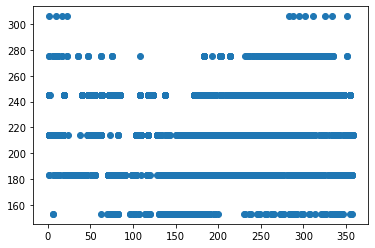

In [113]:
plt.scatter(full_predictions['doy'], full_predictions['flowering_day'])

Idea for corrections: take the lower error between the base error and the year-transformed error.

NEW TRAINING PARADIGM:
Specific data if possible, more generalized data if not.
Ex. use European high-time-res data if possible, otherwise use monthly data. 
Use species if possible, otherwise use genus. 

Update: this did not work. the genus models are much less accurate. 

However, these seem better than the "old" models?

Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

High error is driven by southern hemisphere and "date wrapping". 

Removing southern hemisphere data and dates that are either very early in the year or very late works a little better.

Ok, median error seems to be a better error metric. the old (coarse) method had a Median Absolute Error of 25, while this one has one of 14. 

After doing some more analysis, 71% of observations fall under the mean (30 days) and 81% fall under the standard deviation (43 days). 

**Trying with no northern hemisphere / Date Wrapping**

In [98]:
unwrapped_northern_preds = full_predictions.query('latitude > 0 and doy > 60')

In [100]:
unwrapped_northern_preds.sort_values('corrected_error', ascending=False)[0:50]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error,square_error,corrected_error
50,2,38.376015,63.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,182.0,33124.0,182.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,182.0,33124.0,182.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516,Malus sieboldii,38.4,237.5,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516,Malus,43.0,281.2,245,182.0,33124.0,182.0


(array([1202., 1016.,  889.,  966.,  796.,  570.,  770.,  550.,  277.,
         426.,  323.,  354.,  316.,  364.,  291.,  216.,  192.,  212.,
         123.,  184.,  195.,  164.,   87.,  110.,   42.,   88.,   64.,
          32.,   75.,   44.,   94.,   46.,   13.,   85.,   29.,   43.,
          13.,   83.,   80.,   31.,   21.,   80.,  110.,   93.,  223.,
         200.,   62.,  319.,   40.,   56.]),
 array([  0.  ,   3.64,   7.28,  10.92,  14.56,  18.2 ,  21.84,  25.48,
         29.12,  32.76,  36.4 ,  40.04,  43.68,  47.32,  50.96,  54.6 ,
         58.24,  61.88,  65.52,  69.16,  72.8 ,  76.44,  80.08,  83.72,
         87.36,  91.  ,  94.64,  98.28, 101.92, 105.56, 109.2 , 112.84,
        116.48, 120.12, 123.76, 127.4 , 131.04, 134.68, 138.32, 141.96,
        145.6 , 149.24, 152.88, 156.52, 160.16, 163.8 , 167.44, 171.08,
        174.72, 178.36, 182.  ]),
 <BarContainer object of 50 artists>)

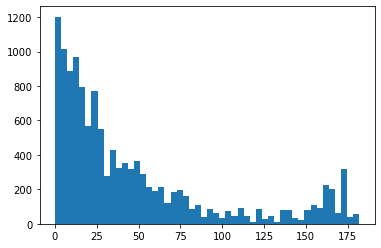

In [101]:
plt.hist(full_predictions['corrected_error'], bins=50)

In [102]:
np.median(full_predictions['abs_error'])

26.0

In [103]:
print(unwrapped_northern_preds)

print(rmse(unwrapped_northern_preds['doy'], unwrapped_northern_preds['flowering_day']))
print(mae(unwrapped_northern_preds['doy'], unwrapped_northern_preds['flowering_day']))

        site_id   latitude    doy    year  genus     lon_360  phenophase  \
19      1812903  42.000443  183.0  2022.0  Rubus  268.349632         516   
20      1812992  43.123822  181.0  2022.0  Rubus  282.422069         516   
22      1813012  35.219765  190.0  2022.0  Rubus  270.150501         516   
23      1813095  43.026309  193.0  2022.0  Rubus  274.317216         516   
25      1810562  37.417095  165.0  2022.0  Rubus  280.809241         516   
...         ...        ...    ...     ...    ...         ...         ...   
148824  1821644  39.903535  251.0  2022.0  Pyrus  255.017318         516   
148825  1814107  39.981231  229.0  2022.0  Pyrus  276.847639         516   
148834  1822209  35.623004  264.0  2022.0  Pyrus  262.402859         516   
148838  1822962  41.593695  286.0  2022.0  Pyrus  276.353681         516   
148859  1821277  45.499888  244.0  2022.0  Pyrus  237.365864         516   

       formatted_sci_name  rounded_lat  rounded_lon  flowering_day  abs_error  \
19    

In [ ]:
def rmse(y1, y2):
    return np.sqrt(np.mean((y1 - y2) ** 2))

def mae(y1, y2):
    return np.mean(np.abs(y1 - y2))

In [105]:
small_preds = full_predictions.dropna()

In [106]:
print(rmse(full_predictions['doy'], full_predictions['flowering_day']))
print(rmse(small_preds['doy'], small_preds['flowering_day']))
print(mae(full_predictions['doy'], full_predictions['flowering_day']))
print(mae(small_preds['doy'], small_preds['flowering_day']))

73.1063042190295
73.1063042190295
48.30737025041473
48.30737025041473


Old MAE: 31.9; new MAE: 30.6.